# Lab: Clustering using CURE

Data Mining 2021/2022  
Jordi Smit and Gosia Migut  
Revised by Bianca Cosma

**WHAT** This _optional_ lab consists of several programming exercises and insight questions. These exercises are meant to let you practice with the theory covered in: [Chapter 7][1] from "Mining of Massive Datasets" by J. Leskovec, A. Rajaraman, J. D. Ullman.

**WHY** Practicing, both through programming and answering the insight questions, aims at deepening your knowledge and preparing you for the exam. 

**HOW** Follow the exercises in this notebook either on your own or with a friend. Use [StackOverflow][2] to discuss the questions with your peers. For additional questions and feedback please consult the TAs during the assigned lab session. The answers to these exercises will not be provided.

[1]: http://infolab.stanford.edu/~ullman/mmds/ch7.pdf
[2]: https://stackoverflow.com/c/tud-cs/questions

#### Summary

In the following exercises you will implement the CURE algorithm. This is a clustering algorithm designed for very large datasets that don't fit into memory. We will simulate the lack of memory by dividing the data in a list of lists, whereby each sub-list is a different batch that has 'supposedly' been read from disk or some other storage server.

In [1]:
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

## Exercise 1: CURE algorithm
K-means and Hierarchical Clustering are two very well known clustering algorithms. Both these algorithms only work if the entire dataset is in the main memory, which means that there is an upper limit on the amount of data they can cluster. So if we want to go beyond this upper limit we need an algorithm that doesn't need the entire dataset to be in main memory. In this exercise we look at the approach of the CURE algorithm. 

The idea of the CURE algorithm is rather simple. We don't need the entire dataset, since most of the data is very similar. So we take a random sample of the dataset that fits into memory and we cluster this data. We then go through the remaining data points and assign them to the closest cluster.

The CURE algorithm we will be using in this exercise can be summarized with the following pseudocode:

```
data_samples = sample_m_data_points_from_the_dataset()
k_sample_clusters = cluster(data_samples, k)
cure_clusters = []
foreach cluster in k_sample_clusters:
	points = find_k_most_representative_points(cluster)
	centroid = find_centroid(points)
	foreach point in points:
		move point x% towards the centroid
	add cure_cluster(points) to cure_clusters 

foreach dp in remaining data:
	assign dp to cure_cluster of the closest representative point
```

If you are looking for a more detailed explanation, see [this online video lecture](https://www.youtube.com/watch?v=JrOJspZ1CUw) from the authors of the book or read the corresponding book section.

### Step 1: Setup
Let's get started by creating the data structures for this problem.  We have already created a `Cluster` class for you. This class stores its centroid and the data points that have been assigned to it.  This class will be used for the traditional hierarchical clustering.
You can see a summary of its class signature and its documentation using the function `help(Cluster)` or you can look at its implementation in `cure_helper.py`.

In [2]:
from cure_helper import Cluster
# Uncomment the line below if you want to read the documentation
help(Cluster)

Help on class Cluster in module cure_helper:

class Cluster(builtins.object)
 |  Cluster(data)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  data_points_as_cluster(self)
 |      Transforms the data in this cluster into a list of singleton clusters.
 |      This function is stateless.
 |      
 |      
 |      Returns:
 |      List[Cluster]: A list of singleton clusters.
 |  
 |  distance(self, other, distance_measure='closest_point')
 |      Calculates the distance between this cluster and another.
 |      This method will be used for the traditional clustering method (in our case, hierarchical clustering).
 |      
 |      Parameters:
 |      other: Cluster: The cluster we are interested in.
 |      distance_measure: ["closest_point", "mean_squared_distance"]: The type of distance measure to use.
 |      
 |      Retur

In the next cell we import some helper functions we have already created for you: 
 - `load_data`;
 - `plot_clusters`;
 - `plot_data`;
 - `plot_cure_clusters` ;
 - `hierarchical_clustering`;
 - `find_two_closest`.
 
 
You can read their documentation using Python's `help` function, as shown below.

In [3]:
from cure_helper import load_data
from cure_helper import plot_clusters
from cure_helper import plot_data
from cure_helper import plot_cure_clusters
from cure_helper import hierarchical_clustering
from cure_helper import find_two_closest
from cure_helper import find_centroid

# help(load_data)
# help(plot_clusters)
# help(plot_data)
# help(plot_cure_clusters)
# help(hierarchical_clustering)
# help(find_two_closest)
# help(find_centroid)

### Step 2: Create CURE clusters

Let's define the `CureCluster` class. This class has two attributes, namely the `k_most_representative_points` and `data` (a `Cluster` which contains the data points that have been assigned to the `CureCluster`). The class is almost finished. The only thing left to do is to finish the `distance` function.  
**Note:** in this exercise, we will be working with 2-dimensional data.

In [8]:
class CureCluster:
    def __init__(self, k_most_representative_points):
        """
        Parameters:
        k_most_representative_points: np.ndarray: A k x 2 matrix, as in this exercise we are working 
                                                  with 2-dimensional data.
        """
        assert isinstance(k_most_representative_points, np.ndarray)
        assert len(k_most_representative_points.shape) == 2 
        self.k_most_representative_points = k_most_representative_points
        self.data = None
        
    def distance(self, cluster):
        """
        Calculates the distance between the centroid of the cluster passed to the method 
        and the closest representative point in this CureCluster.

        Parameters:
        cluster: Cluster: The cluster for which we need to find the minimum distance between 
                          its centroid and the representative points of this CureCluster.

        Returns:
        float: Returns the distance as a float.
        """
        min_dist = sys.float_info.max
        
        # START ANSWER
        for point in self.k_most_representative_points:
            if np.linalg.norm(point - cluster.centroid) < min_dist:
                min_dist = np.linalg.norm(point - cluster.centroid)
        # END ANSWER
        
        return min_dist
    
    def append(self, cluster):
        """
        Adds the data points in the input cluster to this CureCluster.
        Is stateful.

        Parameters:
        cluster: Cluster: A cluster that contains the data points we want to add.
        """
        if self.data is None:
            self.data = cluster
        else:
            self.data = self.data.merge(cluster)
    
    def __repr__(self):
        return f"CureCluster(\nrepresentative_points:\n{self.k_most_representative_points},\ndata: \n{self.data}\n)\n"

# Check that your distance function works on a simple example.
test_cluster = Cluster(np.array([[4, 3], [3, 3], [3, 3.5], [3, 4], [5, 4], [5, 4.5], [4, 4]]))
test_cure_cluster = CureCluster(np.array([[1, 1], [3, 1], [2, 2]]))
assert np.isclose(test_cure_cluster.distance(test_cluster), 2.5274008589934476, atol=0.0001)

### Step 3: Implement the CURE algorithm
Next, let's define the `find_k_most_representative_points` function. We'll use this function to find the $k$ most representative points in a cluster.

The $k$ most representative points of a cluster should be chosen such that they are far away from one another. One way to do this is to follow the first method described in subsection 7.3.2 of the book, which also includes the pseudocode and an example. First, we will pick one point at random and add it to the list of representative points. As long as the size of this list is less than $k$, we will keep adding points from the cluster to this list, each time selecting the point with the largest minimum distance to the representative points in the list.

In [18]:
def find_point_with_largest_minimum_distance(cluster, representative_points):
    """
    For the given cluster, this function should find the point in the cluster whose
    minimum distance to the representative points is the largest.
    
    Parameters:
    cluster: Cluster: The cluster we are interested in.
    representative_points: A list of representative points in the cluster.

    Returns:
    np.array: A numpy array with two elements, representing the coordinates of the point.
    """
    max_distance = -np.inf
    point_with_max_distance = None
    
    # START ANSWER
    for point in cluster.data:
        min_dist = np.inf
        for rep_point in representative_points:
            if rep_point[0] == point[0] and rep_point[1] == point[1]:
                min_dist = -np.inf
            min_dist = min(min_dist, np.linalg.norm(point-rep_point))
            
        if max_distance < min_dist:
            max_distance = min_dist
            point_with_max_distance = point
    # END ANSWER  
    
    return point_with_max_distance
        
        
def find_k_most_representative_points(cluster, k, seed):
    """
    Finds the k most representative points of a given cluster.
    
    Parameters:
    cluster: Cluster: The cluster we are interested in.
    k: int: The amount of representative points.
    seed: int: A random seed.

    Returns:
    np.ndarray: Returns a k x 2 matrix, where each row contains a representative point.
    """
    
    # Pick the first point randomly and add it to the set of the k most representative points.
    random.seed(seed)
    first_point = cluster.data[random.randint(0, cluster.data.shape[0] - 1)]
    k_most_representative_points = [first_point]
    
    # Determine the remaining (k-1) representative points, by making use of the function
    # you implemented before.
    # START ANSWER
    while(len(k_most_representative_points) < k):
        k_most_representative_points.append(find_point_with_largest_minimum_distance(cluster, k_most_representative_points))
    # END ANSWER
    
    return np.array(k_most_representative_points)

# Check that your method to find the k most representative points works on a simple example.
resulting_k_representative_points = np.sort(find_k_most_representative_points(test_cluster, 3, 42), axis=0)
print(resulting_k_representative_points)
assert np.array_equal(resulting_k_representative_points, 
                      [[3, 3], [4, 4], [5, 4.5]])

[[3.  3. ]
 [4.  4. ]
 [5.  4.5]]


Now, we'll combine the previously defined functions, and write the function `transform_into_cure_cluster`, which converts a `Cluster` into a `CureCluster`. It's your job to find the `k_most_representative_points` and to move them before we create the `CureCluster`.<br>
**Hint**: Carefully look at the pseudo code of the algorithm.

In [20]:
def transform_into_cure_cluster(cluster, representative_points, move_to_center_percentage, seed):
    """
    Transforms a given cluster into a CureCluster by:
    1. selecting the k most representative points from the data points in the cluster.
    2. moving the k representative points towards the centroid of the cluster by a given percentage.
    
    Parameters:
    cluster: Cluster: The cluster we want to transform.
    representative_points: int: The number of representative_points.
    move_to_center_percentage: float: A value between 0 and 1, 
                                      representing how much the k points should be moved towards their centroid.
    seed: int: A random seed, to be passed to find_k_most_representative_points.

    Returns:
    CureCluster: Returns a new CureCluster with its representative points.
    """
    
    assert 0 < move_to_center_percentage < 1, "The value of move_to_center_percentage must be in the range (0,1)"
    if representative_points > len(cluster):
        print(f"[Warning] representative_points has been changed to {len(cluster)} for this cluster.")
        representative_points = len(cluster)
    
    k_most_representative_points = find_k_most_representative_points(cluster, representative_points, seed)
    centroid = cluster.centroid
    for i in range(len(k_most_representative_points)):
        point = k_most_representative_points[i]
        point += move_to_center_percentage * (centroid - point)
    
    cure_cluster = CureCluster(k_most_representative_points)
    cure_cluster.append(cluster)
    return cure_cluster

# Check that your implementation works on a simple example.
assert np.allclose(np.sort(transform_into_cure_cluster(test_cluster, 3, 0.2, 42).k_most_representative_points, axis=0),
                   [[3.17142857, 3.14285714], [3.97142857, 3.94285714], [4.77142857, 4.34285714]], atol=0.001)

Finally, let's define the `find_cure_cluster_with_min_dist` function. It's your job to find and return the `CureCluster` in the input list that is closest to the input `Cluster`.

In [21]:
def find_cure_cluster_with_min_dist(cure_clusters, cluster):
    """
    Parameters:
    cure_clusters: List[CureCluster]: The cure clusters we want to compare against.
    cluster: Cluster: The cluster we are interested in.

    Returns:
    CureCluster: Returns the CureCluster with the minimum distance to the given cluster.
    """
    
    cure_cluster_with_min_dist = None
    min_dist = np.inf
    # START ANSWER
    for cl in cure_clusters:
        if min_dist > cl.distance(cluster):
            min_dist = cl.distance(cluster)
            cure_cluster_with_min_dist = cl
    # END ANSWER
    
    return cure_cluster_with_min_dist

# Check that your implementation works on a simple example.
test_cure_cluster2 = CureCluster(np.array([[0.5, 0.5], [0, 0], [-0.3, -0.3]]))
list_of_test_cure_clusters = [test_cure_cluster, test_cure_cluster2]
assert find_cure_cluster_with_min_dist(list_of_test_cure_clusters, test_cluster) == test_cure_cluster

### Step 4: Apply the algorithm

These are the hyperparameters of the algorithm:

 - `seed`: A random seed to ensure that the random sampling returns the same result between different runs;
 - `sample_size`: The amount of random samples we use to find the $k$ clusters;
 - `representative_points`: The number of representative points we take from the $k$ clusters;
 - `n_clusters`: The number of clusters we want to find at the end of the CURE algorithm;
 - `move_to_center_percentage`: How much the k representative points will be moved towards their centroid.
 
We have two sets: `data/cluster.txt` and `data/cluster_lines.txt`. Try to find the correct hyperparameters for both sets.

In [36]:
# CURE parameters
seed = 42

# Set the remaining 4 hyperparameters.
# START ANSWER
sample_size = 200
representative_points = 10
n_clusters = 3
move_to_center_percentage = 0.2
# END ANSWER

# Data set 1.
file_path = "data/cluster.txt"

# Data set 2.
# file_path = "data/cluster_lines.txt"

First let's see what the data looks like.

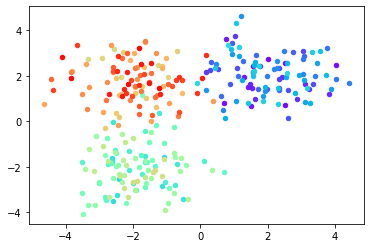

In [37]:
data = load_data(file_path)
plot_clusters(data)

Next, let's sample some random points. 

Your task is to make sure that you have enough samples in each cluster. If this does not seem to be the case you might want to change your hyperparameters.

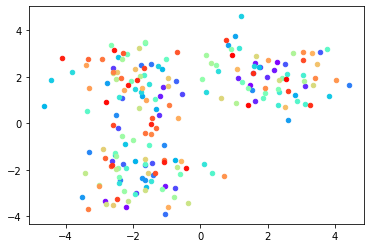

In [38]:
random.seed(seed)
data_sample = random.sample(data, sample_size)
plot_clusters(data_sample)

Let's assume we have a good, well distributed random sample from the data. 

Now let's perform traditional hierarchical clustering on this sample of the data set. Visually, the resulting clusters should resemble the ones we were able to distinguish in the plot of the complete data set.

Depending on the dataset you are working with, you may have to pick a different distance measure to be used for the traditional clustering. You can choose between "closest_point" and "mean_squared_distance". Try to see which one works best for each dataset.

The resulting clusters of the sample data:


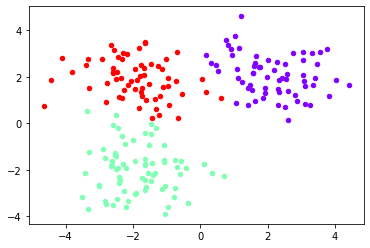

In [39]:
# Pick a distance measure.
distance_measure="mean_squared_distance"

# Cluster samples with hierarchical clustering.
sample_clusters = hierarchical_clustering(data_sample, k=n_clusters, distance_measure=distance_measure)
print("The resulting clusters of the sample data:")
plot_clusters(sample_clusters)

Now let's use the clusters to create $k$ CURE clusters with the functions you have implemented. Then let's loop through all the data and let's assign each data point to the correct CURE cluster. On the plot you will see data points marked with dots and representative points marked with diamonds.

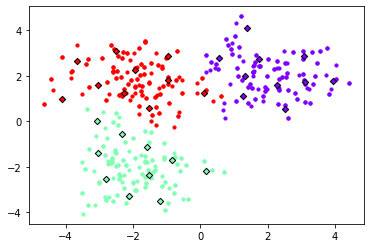

In [40]:
# Create CURE Clusters.
cure_clusters = [transform_into_cure_cluster(cluster, representative_points, move_to_center_percentage, seed) for cluster in sample_clusters]

# Assign remaining data points to the clusters.
for dp in data:
    cure_cluster = find_cure_cluster_with_min_dist(cure_clusters, dp)
    cure_cluster.append(dp) 

plot_cure_clusters(cure_clusters)

If you have implemented everything correctly and you have chosen some good hyperparameters, then your results from the CURE version should be similar to the result of the traditional hierarchical clustering function you see below.

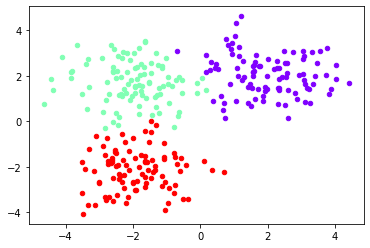

In [41]:
full_data_set_results = hierarchical_clustering(data, k=n_clusters, distance_measure=distance_measure)
plot_clusters(full_data_set_results)

$\textbf{Question 1}$: What is the advantage of CURE over the BFR algorithm?

$\textbf{Question 2}$: What happens if the `sample_size` hyperparameter is too high or too low?

$\textbf{Question 3}$: What happens if the `representative_points` hyperparameter is too high or too low?

$\textbf{Question 4}$: When performing hierarchical clustering of the initially sampled points, you could choose between 2 distance measures. What is the effect of different distance measures on the final result?